## Import

In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [3]:
CFG = {
    'IMG_SIZE':512,
    'EPOCHS':300,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':16,
    'SEED':50
}

## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing
#### 1. Load Dataframe
#### 2. 결측치 보완
#### 3. Train / Validation Split
#### 4. Numeric Feature Scaling / Categorical Featrue Label-Encoding

In [5]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [6]:
train_df['암의 장경'] = train_df['암의 장경'].fillna(train_df['암의 장경'].mean())
train_df = train_df.fillna(0)

test_df['암의 장경'] = test_df['암의 장경'].fillna(train_df['암의 장경'].mean())
test_df = test_df.fillna(0)

In [7]:
train_df, val_df, train_labels, val_labels = train_test_split(
                                                    train_df.drop(columns=['N_category']), 
                                                    train_df['N_category'], 
                                                    test_size=0.2, 
                                                    random_state=CFG['SEED'],
                                                    stratify=train_df['N_category']
                                                    
                                                )

In [8]:
def get_values(value):
    return value.values.reshape(-1, 1)

numeric_cols = ['나이', '암의 장경', 'ER_Allred_score', 'PR_Allred_score', 'KI-67_LI_percent', 'HER2_SISH_ratio']
ignore_cols = ['ID', 'img_path', 'mask_path', '수술연월일', 'N_category']

for col in train_df.columns:
    if col in ignore_cols:
        continue
    if col in numeric_cols:
        scaler = StandardScaler()
        train_df[col] = scaler.fit_transform(get_values(train_df[col]))
        val_df[col] = scaler.transform(get_values(val_df[col]))
        test_df[col] = scaler.transform(get_values(test_df[col]))
    else:
        le = LabelEncoder()
        train_df[col] = le.fit_transform(get_values(train_df[col]))
        val_df[col] = le.transform(get_values(val_df[col]))
        test_df[col] = le.transform(get_values(test_df[col]))

## CustomDataset

In [9]:
class CustomDataset(Dataset):
    def __init__(self, medical_df, labels, transforms=None):
        self.medical_df = medical_df
        self.transforms = transforms
        self.labels = labels
        
    def __getitem__(self, index):
        img_path = self.medical_df['img_path'].iloc[index]
        img_folder = 'C:\\Users\\sanda\\Desktop\\dacon\\img_features\\'
        img_name = img_path.split('/')[-1]
        img_name = img_name.split('.')[0]
        #print(img_name)
        
        feature_path = img_folder + img_name + '_img_feature.npy'
        #print(feature_path)
        image_feature = np.load(feature_path) # fixed
        image_feature = torch.from_numpy(image_feature)
        image_feature = image_feature.permute(2,0,1)
        image_feature = F.adaptive_max_pool2d(image_feature, (1))
        image_feature = image_feature.squeeze(1)
        image_feature = image_feature.squeeze(1)
        
        #print(image_feature.shape)
        
        if self.transforms is not None:
            pass
            #image = self.transforms(image=image)['image']
                
        if self.labels is not None:
            tabular = torch.Tensor(self.medical_df.drop(columns=['ID', 'img_path', 'mask_path', '수술연월일']).iloc[index])
            label = self.labels[index]
            return image_feature, tabular, label
        else:
            tabular = torch.Tensor(self.medical_df.drop(columns=['ID', 'img_path', '수술연월일']).iloc[index])
            return image_feature, tabular
        
    def __len__(self):
        return len(self.medical_df)

In [10]:
train_transforms = A.Compose([
#                             A.HorizontalFlip(),
#                             A.VerticalFlip(),
#                             A.Rotate(limit=90, border_mode=cv2.BORDER_CONSTANT,p=0.3),
#                             A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
#                             A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transforms = A.Compose([
#                             A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
#                             A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [11]:
train_dataset = CustomDataset(train_df, train_labels.values, train_transforms)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_df, val_labels.values, test_transforms)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

## Model Architecture

In [12]:
class ImgFeatureExtractor(nn.Module):
    def __init__(self):
        super(ImgFeatureExtractor, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(in_features=2048, out_features=2048),
            nn.BatchNorm1d(2048),
            nn.GELU(),
            nn.Linear(in_features=2048, out_features=2048),
        )
        
    def forward(self, x):
        x = self.embedding(x)
        return x

In [13]:
class TabularFeatureExtractor(nn.Module):
    def __init__(self):
        super(TabularFeatureExtractor, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(in_features=23, out_features=128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Linear(in_features=128, out_features=256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Linear(in_features=256, out_features=512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Linear(in_features=512, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Linear(in_features=1024, out_features=2048),
            nn.BatchNorm1d(2048),
            nn.GELU(),
            nn.Linear(in_features=2048, out_features=2048),
        )
        
    def forward(self, x):
        x = self.embedding(x)
        return x

In [14]:
class residual(nn.Module):
    def __init__(self,size):
        super(residual, self).__init__()
        self.size = size
        #self.half_size = size // 2
        self.resi = nn.Sequential(
            nn.Linear(in_features=size, out_features=size // 2),
            nn.BatchNorm1d(size // 2),
            nn.GELU(),
            nn.Linear(in_features=size // 2, out_features=size),
        )
        
    def forward(self, x):
        x = self.resi(x)
        return x

In [15]:
class half_layer(nn.Module):
    def __init__(self,size):
        super(half_layer, self).__init__()
        self.size = size
        self.tohalf = nn.Sequential(
            nn.Linear(in_features=size, out_features=size // 2),
            nn.BatchNorm1d(size // 2),
            nn.GELU(),
            nn.Linear(in_features=size // 2, out_features=size // 2),
        )
        
    def forward(self, x):
        x = self.tohalf(x)
        return x

In [16]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.img_feature_extractor = ImgFeatureExtractor()
        self.tabular_feature_extractor = TabularFeatureExtractor()
        
        self.residual_block5 = residual(4096)
        self.residual_block5_1 = residual(4096)
        self.half_layer5 = half_layer(4096)
        
        self.residual_block4 = residual(2048)
        self.residual_block4_1 = residual(2048)
        self.half_layer4 = half_layer(2048)
        
        self.residual_block3 = residual(1024)
        self.residual_block3_1 = residual(1024)
        self.half_layer3 = half_layer(1024)
        
        self.residual_block2 = residual(512)
        self.residual_block2_1 = residual(512)
        self.half_layer2 = half_layer(512)
        
        self.residual_block1 = residual(256)
        self.residual_block1_1 = residual(256)
        self.half_layer1 = half_layer(256)
        
        self.residual_block0 = residual(128)
        self.residual_block0_1 = residual(128)
        self.half_layer0 = half_layer(128)
        
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=64, out_features=1),
            nn.Sigmoid(),
        )
        
    def forward(self, img, tabular):
        img_feature = self.img_feature_extractor(img)

        tabular_feature = self.tabular_feature_extractor(tabular)
     
        feature = torch.cat([img_feature, tabular_feature], dim=-1)

        feature = self.residual_block5(feature) + feature
        feature = self.residual_block5_1(feature) + feature
        feature = self.half_layer5(feature)
        
        feature = self.residual_block4(feature) + feature
        feature = self.residual_block4_1(feature) + feature
        feature = self.half_layer4(feature)
        
        feature = self.residual_block3(feature) + feature
        feature = self.residual_block3_1(feature) + feature
        feature = self.half_layer3(feature)
        
        feature = self.residual_block2(feature) + feature
        feature = self.residual_block2_1(feature) + feature
        feature = self.half_layer2(feature)
        
        feature = self.residual_block1(feature) + feature
        feature = self.residual_block1_1(feature) + feature
        feature = self.half_layer1(feature)
        
        feature = self.residual_block0(feature) + feature
        feature = self.residual_block0_1(feature) + feature
        feature = self.half_layer0(feature)
        
        output = self.classifier(feature)
        
        return output

## Train

In [17]:
import copy

train_loss_list = []
val_loss_list = []
val_acc_list = []

def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    
    best_score = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for img, tabular, label in tqdm(iter(train_loader)):
            img = img.float().to(device)
            tabular = tabular.float().to(device)
            label = label.float().to(device)
            
            optimizer.zero_grad()
            
            model_pred = model(img, tabular)
            
            loss = criterion(model_pred, label.reshape(-1,1))
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        val_loss, val_score = validation(model, criterion, val_loader, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] Val Score : [{val_score:.5f}]')
        train_loss_list.append(np.mean(train_loss))
        val_loss_list.append(val_loss)
        val_acc_list.append(val_score)
        
        if scheduler is not None:
            scheduler.step(val_score)
        
        if best_score < val_score:
            best_score = val_score
            best_model = model
            best_model_weights = copy.deepcopy(best_model.state_dict())
            torch.save(best_model_weights,os.path.join('./MIL_clf_model_trained.pt'))
            print("best 모델 저장됨")
    
    return best_model

In [18]:
def validation(model, criterion, val_loader, device):
    model.eval()
    pred_labels = []
    true_labels = []
    val_loss = []
    threshold = 0.5
    with torch.no_grad():
        for img, tabular, label in tqdm(iter(val_loader)):
            true_labels += label.tolist()
            
            img = img.float().to(device)
            tabular = tabular.float().to(device)
            label = label.float().to(device)
            
            model_pred = model(img, tabular)
            
            loss = criterion(model_pred, label.reshape(-1,1))
            
            val_loss.append(loss.item())
            
            model_pred = model_pred.squeeze(1).to('cpu')  
            pred_labels += model_pred.tolist()
    
    pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
    val_score = metrics.f1_score(y_true=true_labels, y_pred=pred_labels, average='macro')
    return np.mean(val_loss), val_score

## Run!!

In [19]:
model = ClassificationModel()

model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.67219] Val Loss : [0.64939] Val Score : [0.76605]
best 모델 저장됨


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.62511] Val Loss : [0.59833] Val Score : [0.84962]
best 모델 저장됨


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.61011] Val Loss : [0.59279] Val Score : [0.83960]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.59468] Val Loss : [0.62661] Val Score : [0.69206]
Epoch 00004: reducing learning rate of group 0 to 5.0000e-05.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.58574] Val Loss : [0.58393] Val Score : [0.81818]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.57023] Val Loss : [0.60783] Val Score : [0.74694]
Epoch 00006: reducing learning rate of group 0 to 2.5000e-05.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.56777] Val Loss : [0.59216] Val Score : [0.80441]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.55677] Val Loss : [0.59510] Val Score : [0.80322]
Epoch 00008: reducing learning rate of group 0 to 1.2500e-05.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.54326] Val Loss : [0.59015] Val Score : [0.82993]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.54134] Val Loss : [0.58237] Val Score : [0.83380]
Epoch 00010: reducing learning rate of group 0 to 6.2500e-06.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.53468] Val Loss : [0.58730] Val Score : [0.81500]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.53760] Val Loss : [0.58520] Val Score : [0.81971]
Epoch 00012: reducing learning rate of group 0 to 3.1250e-06.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.53287] Val Loss : [0.58667] Val Score : [0.82479]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.52758] Val Loss : [0.58788] Val Score : [0.82479]
Epoch 00014: reducing learning rate of group 0 to 1.5625e-06.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.52700] Val Loss : [0.58991] Val Score : [0.81488]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.53409] Val Loss : [0.58311] Val Score : [0.83467]
Epoch 00016: reducing learning rate of group 0 to 7.8125e-07.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.52909] Val Loss : [0.58778] Val Score : [0.81993]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.52646] Val Loss : [0.58842] Val Score : [0.82496]
Epoch 00018: reducing learning rate of group 0 to 3.9063e-07.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.52602] Val Loss : [0.58357] Val Score : [0.83430]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.53182] Val Loss : [0.58350] Val Score : [0.82939]
Epoch 00020: reducing learning rate of group 0 to 1.9531e-07.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.52839] Val Loss : [0.58748] Val Score : [0.81935]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.53187] Val Loss : [0.58616] Val Score : [0.83490]
Epoch 00022: reducing learning rate of group 0 to 9.7656e-08.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.52361] Val Loss : [0.58820] Val Score : [0.81496]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.52454] Val Loss : [0.58211] Val Score : [0.84453]
Epoch 00024: reducing learning rate of group 0 to 4.8828e-08.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.52663] Val Loss : [0.58755] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.52665] Val Loss : [0.58791] Val Score : [0.82464]
Epoch 00026: reducing learning rate of group 0 to 2.4414e-08.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.52692] Val Loss : [0.58622] Val Score : [0.82985]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.52786] Val Loss : [0.58794] Val Score : [0.82489]
Epoch 00028: reducing learning rate of group 0 to 1.2207e-08.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.52349] Val Loss : [0.58425] Val Score : [0.83467]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.52467] Val Loss : [0.58609] Val Score : [0.82479]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [31], Train Loss : [0.52934] Val Loss : [0.58617] Val Score : [0.82464]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [32], Train Loss : [0.52888] Val Loss : [0.58679] Val Score : [0.82985]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [33], Train Loss : [0.52952] Val Loss : [0.58749] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [34], Train Loss : [0.52743] Val Loss : [0.58613] Val Score : [0.81911]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [35], Train Loss : [0.52644] Val Loss : [0.58737] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [36], Train Loss : [0.52877] Val Loss : [0.58619] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [37], Train Loss : [0.52684] Val Loss : [0.58543] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [38], Train Loss : [0.52879] Val Loss : [0.58318] Val Score : [0.83467]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [39], Train Loss : [0.52810] Val Loss : [0.58455] Val Score : [0.82401]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [40], Train Loss : [0.52873] Val Loss : [0.58827] Val Score : [0.81422]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [41], Train Loss : [0.53056] Val Loss : [0.58450] Val Score : [0.81884]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [42], Train Loss : [0.52425] Val Loss : [0.58653] Val Score : [0.82957]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [43], Train Loss : [0.52662] Val Loss : [0.59348] Val Score : [0.83000]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [44], Train Loss : [0.52628] Val Loss : [0.58502] Val Score : [0.81935]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [45], Train Loss : [0.52365] Val Loss : [0.58586] Val Score : [0.83467]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [46], Train Loss : [0.52552] Val Loss : [0.58804] Val Score : [0.83986]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [47], Train Loss : [0.52995] Val Loss : [0.58638] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [48], Train Loss : [0.52775] Val Loss : [0.58607] Val Score : [0.83986]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [49], Train Loss : [0.52768] Val Loss : [0.58640] Val Score : [0.82985]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [50], Train Loss : [0.52373] Val Loss : [0.58716] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [51], Train Loss : [0.52855] Val Loss : [0.58571] Val Score : [0.82447]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [52], Train Loss : [0.53101] Val Loss : [0.58986] Val Score : [0.81998]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [53], Train Loss : [0.52710] Val Loss : [0.58831] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [54], Train Loss : [0.52922] Val Loss : [0.58092] Val Score : [0.83942]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [55], Train Loss : [0.52445] Val Loss : [0.58618] Val Score : [0.81488]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [56], Train Loss : [0.52628] Val Loss : [0.58585] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [57], Train Loss : [0.52947] Val Loss : [0.58494] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [58], Train Loss : [0.52923] Val Loss : [0.59055] Val Score : [0.82496]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [59], Train Loss : [0.52537] Val Loss : [0.58714] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [60], Train Loss : [0.52452] Val Loss : [0.58322] Val Score : [0.83450]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [61], Train Loss : [0.52524] Val Loss : [0.58991] Val Score : [0.82993]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [62], Train Loss : [0.53035] Val Loss : [0.58518] Val Score : [0.82464]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [63], Train Loss : [0.52221] Val Loss : [0.58966] Val Score : [0.81500]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [64], Train Loss : [0.52950] Val Loss : [0.58299] Val Score : [0.83430]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [65], Train Loss : [0.52304] Val Loss : [0.58544] Val Score : [0.83467]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [66], Train Loss : [0.53116] Val Loss : [0.58675] Val Score : [0.82464]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [67], Train Loss : [0.52922] Val Loss : [0.58294] Val Score : [0.83430]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [68], Train Loss : [0.52395] Val Loss : [0.58697] Val Score : [0.83496]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [69], Train Loss : [0.52296] Val Loss : [0.58784] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [70], Train Loss : [0.52905] Val Loss : [0.58636] Val Score : [0.81365]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [71], Train Loss : [0.53613] Val Loss : [0.58415] Val Score : [0.82447]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [72], Train Loss : [0.53253] Val Loss : [0.58565] Val Score : [0.82479]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [73], Train Loss : [0.52523] Val Loss : [0.58748] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [74], Train Loss : [0.52449] Val Loss : [0.58111] Val Score : [0.84434]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [75], Train Loss : [0.52855] Val Loss : [0.58634] Val Score : [0.82464]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [76], Train Loss : [0.52618] Val Loss : [0.58619] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [77], Train Loss : [0.52434] Val Loss : [0.58422] Val Score : [0.83450]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [78], Train Loss : [0.53248] Val Loss : [0.58751] Val Score : [0.83490]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [79], Train Loss : [0.52648] Val Loss : [0.59161] Val Score : [0.81998]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [80], Train Loss : [0.52880] Val Loss : [0.58553] Val Score : [0.82985]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [81], Train Loss : [0.52899] Val Loss : [0.58464] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [82], Train Loss : [0.53078] Val Loss : [0.58557] Val Score : [0.82939]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [83], Train Loss : [0.52874] Val Loss : [0.58990] Val Score : [0.81998]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [84], Train Loss : [0.52750] Val Loss : [0.58886] Val Score : [0.82479]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [85], Train Loss : [0.52684] Val Loss : [0.58249] Val Score : [0.82426]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [86], Train Loss : [0.52629] Val Loss : [0.58747] Val Score : [0.83490]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [87], Train Loss : [0.52988] Val Loss : [0.58709] Val Score : [0.82985]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [88], Train Loss : [0.52651] Val Loss : [0.58532] Val Score : [0.83450]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [89], Train Loss : [0.53166] Val Loss : [0.58704] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [90], Train Loss : [0.52573] Val Loss : [0.59209] Val Score : [0.82500]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [91], Train Loss : [0.52693] Val Loss : [0.58492] Val Score : [0.82957]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [92], Train Loss : [0.52638] Val Loss : [0.58771] Val Score : [0.81462]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [93], Train Loss : [0.52707] Val Loss : [0.58706] Val Score : [0.82993]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [94], Train Loss : [0.52808] Val Loss : [0.58699] Val Score : [0.83490]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [95], Train Loss : [0.52682] Val Loss : [0.58750] Val Score : [0.81993]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [96], Train Loss : [0.52278] Val Loss : [0.58619] Val Score : [0.82464]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [97], Train Loss : [0.52922] Val Loss : [0.58792] Val Score : [0.82479]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [98], Train Loss : [0.52930] Val Loss : [0.58888] Val Score : [0.83490]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [99], Train Loss : [0.52953] Val Loss : [0.58707] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [100], Train Loss : [0.53068] Val Loss : [0.58326] Val Score : [0.84453]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [101], Train Loss : [0.52680] Val Loss : [0.58368] Val Score : [0.83942]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [102], Train Loss : [0.52842] Val Loss : [0.58364] Val Score : [0.82916]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [103], Train Loss : [0.52483] Val Loss : [0.58959] Val Score : [0.82993]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [104], Train Loss : [0.52236] Val Loss : [0.58505] Val Score : [0.82401]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [105], Train Loss : [0.52869] Val Loss : [0.58815] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [106], Train Loss : [0.52549] Val Loss : [0.58635] Val Score : [0.82464]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [107], Train Loss : [0.53102] Val Loss : [0.58904] Val Score : [0.83490]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [108], Train Loss : [0.52606] Val Loss : [0.58739] Val Score : [0.82464]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [109], Train Loss : [0.52935] Val Loss : [0.58899] Val Score : [0.83986]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [110], Train Loss : [0.52968] Val Loss : [0.58495] Val Score : [0.83450]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [111], Train Loss : [0.52694] Val Loss : [0.58604] Val Score : [0.82957]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [112], Train Loss : [0.52422] Val Loss : [0.58904] Val Score : [0.82993]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [113], Train Loss : [0.52737] Val Loss : [0.58634] Val Score : [0.82464]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [114], Train Loss : [0.52122] Val Loss : [0.58354] Val Score : [0.82957]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [115], Train Loss : [0.52332] Val Loss : [0.58874] Val Score : [0.83986]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [116], Train Loss : [0.52380] Val Loss : [0.58561] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [117], Train Loss : [0.52674] Val Loss : [0.58365] Val Score : [0.82916]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [118], Train Loss : [0.52418] Val Loss : [0.58741] Val Score : [0.81488]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [119], Train Loss : [0.52519] Val Loss : [0.58797] Val Score : [0.83490]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [120], Train Loss : [0.52408] Val Loss : [0.58618] Val Score : [0.81955]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [121], Train Loss : [0.52779] Val Loss : [0.58515] Val Score : [0.82447]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [122], Train Loss : [0.52639] Val Loss : [0.58838] Val Score : [0.82500]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [123], Train Loss : [0.52519] Val Loss : [0.58764] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [124], Train Loss : [0.52721] Val Loss : [0.58460] Val Score : [0.83430]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [125], Train Loss : [0.52332] Val Loss : [0.58655] Val Score : [0.81971]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [126], Train Loss : [0.52592] Val Loss : [0.58845] Val Score : [0.82464]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [127], Train Loss : [0.52774] Val Loss : [0.59115] Val Score : [0.81998]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [128], Train Loss : [0.52529] Val Loss : [0.58778] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [129], Train Loss : [0.53462] Val Loss : [0.59614] Val Score : [0.80460]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [130], Train Loss : [0.52900] Val Loss : [0.58396] Val Score : [0.83942]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [131], Train Loss : [0.52888] Val Loss : [0.58432] Val Score : [0.82916]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [132], Train Loss : [0.52183] Val Loss : [0.59190] Val Score : [0.82000]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [133], Train Loss : [0.52665] Val Loss : [0.58420] Val Score : [0.82401]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [134], Train Loss : [0.52435] Val Loss : [0.58710] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [135], Train Loss : [0.52778] Val Loss : [0.58887] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [136], Train Loss : [0.52444] Val Loss : [0.58372] Val Score : [0.82890]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [137], Train Loss : [0.52707] Val Loss : [0.58760] Val Score : [0.83490]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [138], Train Loss : [0.52595] Val Loss : [0.58837] Val Score : [0.82479]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [139], Train Loss : [0.52598] Val Loss : [0.58980] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [140], Train Loss : [0.52581] Val Loss : [0.58641] Val Score : [0.81971]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [141], Train Loss : [0.52835] Val Loss : [0.58603] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [142], Train Loss : [0.53138] Val Loss : [0.58780] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [143], Train Loss : [0.52760] Val Loss : [0.58714] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [144], Train Loss : [0.53195] Val Loss : [0.58510] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [145], Train Loss : [0.52774] Val Loss : [0.58586] Val Score : [0.83450]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [146], Train Loss : [0.52889] Val Loss : [0.58232] Val Score : [0.83942]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [147], Train Loss : [0.52339] Val Loss : [0.58644] Val Score : [0.82447]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [148], Train Loss : [0.52522] Val Loss : [0.58743] Val Score : [0.81955]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [149], Train Loss : [0.52460] Val Loss : [0.58637] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [150], Train Loss : [0.52837] Val Loss : [0.58305] Val Score : [0.83450]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [151], Train Loss : [0.52480] Val Loss : [0.59557] Val Score : [0.81984]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [152], Train Loss : [0.52704] Val Loss : [0.58790] Val Score : [0.82447]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [153], Train Loss : [0.52601] Val Loss : [0.58697] Val Score : [0.83490]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [154], Train Loss : [0.52689] Val Loss : [0.58565] Val Score : [0.82939]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [155], Train Loss : [0.52365] Val Loss : [0.58561] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [156], Train Loss : [0.52457] Val Loss : [0.58659] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [157], Train Loss : [0.52545] Val Loss : [0.58743] Val Score : [0.82426]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [158], Train Loss : [0.52442] Val Loss : [0.58735] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [159], Train Loss : [0.52688] Val Loss : [0.58895] Val Score : [0.82489]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [160], Train Loss : [0.53122] Val Loss : [0.58556] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [161], Train Loss : [0.53020] Val Loss : [0.58670] Val Score : [0.82890]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [162], Train Loss : [0.52592] Val Loss : [0.58689] Val Score : [0.82957]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [163], Train Loss : [0.52758] Val Loss : [0.58796] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [164], Train Loss : [0.52682] Val Loss : [0.58616] Val Score : [0.82939]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [165], Train Loss : [0.52562] Val Loss : [0.58635] Val Score : [0.82957]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [166], Train Loss : [0.52642] Val Loss : [0.58554] Val Score : [0.82426]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [167], Train Loss : [0.52623] Val Loss : [0.58564] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [168], Train Loss : [0.53089] Val Loss : [0.58730] Val Score : [0.83986]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [169], Train Loss : [0.52458] Val Loss : [0.58693] Val Score : [0.82479]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [170], Train Loss : [0.53060] Val Loss : [0.59095] Val Score : [0.81998]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [171], Train Loss : [0.52436] Val Loss : [0.58793] Val Score : [0.82985]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [172], Train Loss : [0.53187] Val Loss : [0.58575] Val Score : [0.83960]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [173], Train Loss : [0.52864] Val Loss : [0.58767] Val Score : [0.82464]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [174], Train Loss : [0.52378] Val Loss : [0.58275] Val Score : [0.82890]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [175], Train Loss : [0.52890] Val Loss : [0.58910] Val Score : [0.82489]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [176], Train Loss : [0.52418] Val Loss : [0.58751] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [177], Train Loss : [0.52815] Val Loss : [0.59221] Val Score : [0.81998]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [178], Train Loss : [0.52680] Val Loss : [0.58620] Val Score : [0.82916]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [179], Train Loss : [0.52900] Val Loss : [0.58564] Val Score : [0.83430]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [180], Train Loss : [0.52992] Val Loss : [0.58925] Val Score : [0.83986]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [181], Train Loss : [0.52735] Val Loss : [0.58882] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [182], Train Loss : [0.52927] Val Loss : [0.58256] Val Score : [0.83942]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [183], Train Loss : [0.52478] Val Loss : [0.58649] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [184], Train Loss : [0.52610] Val Loss : [0.58857] Val Score : [0.82464]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [185], Train Loss : [0.52570] Val Loss : [0.58869] Val Score : [0.82489]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [186], Train Loss : [0.52681] Val Loss : [0.58635] Val Score : [0.82939]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [187], Train Loss : [0.53136] Val Loss : [0.58377] Val Score : [0.82939]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [188], Train Loss : [0.52412] Val Loss : [0.58974] Val Score : [0.80500]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [189], Train Loss : [0.52546] Val Loss : [0.58533] Val Score : [0.82426]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [190], Train Loss : [0.52417] Val Loss : [0.58669] Val Score : [0.81955]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [191], Train Loss : [0.52740] Val Loss : [0.58530] Val Score : [0.83467]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [192], Train Loss : [0.52374] Val Loss : [0.58717] Val Score : [0.82426]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [193], Train Loss : [0.52754] Val Loss : [0.58779] Val Score : [0.82985]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [194], Train Loss : [0.52302] Val Loss : [0.58700] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [195], Train Loss : [0.52713] Val Loss : [0.58673] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [196], Train Loss : [0.52410] Val Loss : [0.58941] Val Score : [0.82496]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [197], Train Loss : [0.52743] Val Loss : [0.58513] Val Score : [0.81911]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [198], Train Loss : [0.52656] Val Loss : [0.58866] Val Score : [0.82993]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [199], Train Loss : [0.52565] Val Loss : [0.58958] Val Score : [0.82500]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [200], Train Loss : [0.52138] Val Loss : [0.58431] Val Score : [0.82401]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [201], Train Loss : [0.52614] Val Loss : [0.58677] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [202], Train Loss : [0.52732] Val Loss : [0.58826] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [203], Train Loss : [0.52522] Val Loss : [0.58623] Val Score : [0.82939]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [204], Train Loss : [0.52271] Val Loss : [0.58481] Val Score : [0.82401]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [205], Train Loss : [0.52252] Val Loss : [0.58668] Val Score : [0.82985]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [206], Train Loss : [0.52402] Val Loss : [0.59100] Val Score : [0.82500]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [207], Train Loss : [0.52419] Val Loss : [0.58992] Val Score : [0.82993]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [208], Train Loss : [0.52808] Val Loss : [0.58754] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [209], Train Loss : [0.52731] Val Loss : [0.58947] Val Score : [0.82993]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [210], Train Loss : [0.52936] Val Loss : [0.58753] Val Score : [0.83974]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [211], Train Loss : [0.52411] Val Loss : [0.58907] Val Score : [0.82993]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [212], Train Loss : [0.52691] Val Loss : [0.58492] Val Score : [0.82426]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [213], Train Loss : [0.52608] Val Loss : [0.58767] Val Score : [0.82985]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [214], Train Loss : [0.52313] Val Loss : [0.58640] Val Score : [0.82479]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [215], Train Loss : [0.52853] Val Loss : [0.58710] Val Score : [0.81955]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [216], Train Loss : [0.52632] Val Loss : [0.58411] Val Score : [0.83450]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [217], Train Loss : [0.53202] Val Loss : [0.58358] Val Score : [0.82401]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [218], Train Loss : [0.52826] Val Loss : [0.58725] Val Score : [0.83986]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [219], Train Loss : [0.52617] Val Loss : [0.58912] Val Score : [0.82489]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [220], Train Loss : [0.52396] Val Loss : [0.58237] Val Score : [0.82890]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [221], Train Loss : [0.52641] Val Loss : [0.58516] Val Score : [0.82957]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [222], Train Loss : [0.52709] Val Loss : [0.58505] Val Score : [0.82957]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [223], Train Loss : [0.52538] Val Loss : [0.59362] Val Score : [0.81000]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [224], Train Loss : [0.52611] Val Loss : [0.58310] Val Score : [0.83942]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [225], Train Loss : [0.52143] Val Loss : [0.58643] Val Score : [0.83467]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [226], Train Loss : [0.53047] Val Loss : [0.58628] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [227], Train Loss : [0.52777] Val Loss : [0.58412] Val Score : [0.82373]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [228], Train Loss : [0.52699] Val Loss : [0.58692] Val Score : [0.82464]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [229], Train Loss : [0.52298] Val Loss : [0.58928] Val Score : [0.80500]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [230], Train Loss : [0.52482] Val Loss : [0.58667] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [231], Train Loss : [0.52448] Val Loss : [0.58909] Val Score : [0.82993]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [232], Train Loss : [0.52703] Val Loss : [0.58978] Val Score : [0.82500]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [233], Train Loss : [0.52402] Val Loss : [0.58963] Val Score : [0.80000]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [234], Train Loss : [0.52595] Val Loss : [0.58644] Val Score : [0.81984]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [235], Train Loss : [0.52544] Val Loss : [0.58634] Val Score : [0.82464]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [236], Train Loss : [0.52419] Val Loss : [0.58890] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [237], Train Loss : [0.52406] Val Loss : [0.58809] Val Score : [0.82479]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [238], Train Loss : [0.52835] Val Loss : [0.58573] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [239], Train Loss : [0.52369] Val Loss : [0.59298] Val Score : [0.81993]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [240], Train Loss : [0.52905] Val Loss : [0.58615] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [241], Train Loss : [0.52125] Val Loss : [0.58811] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [242], Train Loss : [0.52320] Val Loss : [0.58768] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [243], Train Loss : [0.52680] Val Loss : [0.58781] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [244], Train Loss : [0.52796] Val Loss : [0.58518] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [245], Train Loss : [0.53585] Val Loss : [0.58819] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [246], Train Loss : [0.53264] Val Loss : [0.59566] Val Score : [0.81477]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [247], Train Loss : [0.52583] Val Loss : [0.58868] Val Score : [0.83490]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [248], Train Loss : [0.52950] Val Loss : [0.58789] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [249], Train Loss : [0.52351] Val Loss : [0.59537] Val Score : [0.80476]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [250], Train Loss : [0.52990] Val Loss : [0.58306] Val Score : [0.83450]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [251], Train Loss : [0.52316] Val Loss : [0.58709] Val Score : [0.81477]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [252], Train Loss : [0.53086] Val Loss : [0.58430] Val Score : [0.81332]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [253], Train Loss : [0.52609] Val Loss : [0.58435] Val Score : [0.82426]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [254], Train Loss : [0.52267] Val Loss : [0.58130] Val Score : [0.83430]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [255], Train Loss : [0.52514] Val Loss : [0.58692] Val Score : [0.83986]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [256], Train Loss : [0.52382] Val Loss : [0.58747] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [257], Train Loss : [0.52489] Val Loss : [0.58403] Val Score : [0.83450]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [258], Train Loss : [0.52413] Val Loss : [0.58990] Val Score : [0.80998]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [259], Train Loss : [0.52374] Val Loss : [0.58958] Val Score : [0.83986]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [260], Train Loss : [0.52751] Val Loss : [0.58443] Val Score : [0.81853]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [261], Train Loss : [0.52549] Val Loss : [0.58728] Val Score : [0.83490]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [262], Train Loss : [0.52846] Val Loss : [0.58710] Val Score : [0.81971]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [263], Train Loss : [0.53203] Val Loss : [0.58853] Val Score : [0.83490]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [264], Train Loss : [0.52271] Val Loss : [0.58524] Val Score : [0.83467]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [265], Train Loss : [0.52621] Val Loss : [0.58485] Val Score : [0.83960]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [266], Train Loss : [0.52210] Val Loss : [0.58742] Val Score : [0.82489]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [267], Train Loss : [0.52548] Val Loss : [0.58824] Val Score : [0.84490]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [268], Train Loss : [0.52966] Val Loss : [0.58226] Val Score : [0.84453]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [269], Train Loss : [0.52417] Val Loss : [0.58700] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [270], Train Loss : [0.52754] Val Loss : [0.58896] Val Score : [0.81488]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [271], Train Loss : [0.52608] Val Loss : [0.58998] Val Score : [0.81488]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [272], Train Loss : [0.53265] Val Loss : [0.58555] Val Score : [0.82426]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [273], Train Loss : [0.52768] Val Loss : [0.58818] Val Score : [0.81488]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [274], Train Loss : [0.52542] Val Loss : [0.59038] Val Score : [0.83994]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [275], Train Loss : [0.52276] Val Loss : [0.59072] Val Score : [0.81998]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [276], Train Loss : [0.52298] Val Loss : [0.58952] Val Score : [0.83490]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [277], Train Loss : [0.52692] Val Loss : [0.58841] Val Score : [0.82985]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [278], Train Loss : [0.52482] Val Loss : [0.58998] Val Score : [0.82000]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [279], Train Loss : [0.52456] Val Loss : [0.58525] Val Score : [0.82464]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [280], Train Loss : [0.53032] Val Loss : [0.58751] Val Score : [0.82496]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [281], Train Loss : [0.52282] Val Loss : [0.59284] Val Score : [0.81993]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [282], Train Loss : [0.52765] Val Loss : [0.58927] Val Score : [0.82500]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [283], Train Loss : [0.52650] Val Loss : [0.58200] Val Score : [0.83942]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [284], Train Loss : [0.52766] Val Loss : [0.58337] Val Score : [0.82916]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [285], Train Loss : [0.52184] Val Loss : [0.58622] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [286], Train Loss : [0.53047] Val Loss : [0.58896] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [287], Train Loss : [0.52840] Val Loss : [0.58742] Val Score : [0.81911]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [288], Train Loss : [0.52406] Val Loss : [0.59258] Val Score : [0.81000]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [289], Train Loss : [0.52594] Val Loss : [0.58341] Val Score : [0.82916]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [290], Train Loss : [0.52279] Val Loss : [0.58562] Val Score : [0.81935]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [291], Train Loss : [0.52815] Val Loss : [0.58647] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [292], Train Loss : [0.52869] Val Loss : [0.58906] Val Score : [0.82496]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [293], Train Loss : [0.52441] Val Loss : [0.58573] Val Score : [0.82464]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [294], Train Loss : [0.52343] Val Loss : [0.58882] Val Score : [0.82998]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [295], Train Loss : [0.52260] Val Loss : [0.58422] Val Score : [0.82939]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [296], Train Loss : [0.52822] Val Loss : [0.58572] Val Score : [0.81955]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [297], Train Loss : [0.52609] Val Loss : [0.58550] Val Score : [0.82973]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [298], Train Loss : [0.53249] Val Loss : [0.58789] Val Score : [0.81500]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [299], Train Loss : [0.52269] Val Loss : [0.58834] Val Score : [0.83480]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [300], Train Loss : [0.52581] Val Loss : [0.58559] Val Score : [0.83467]


In [20]:
device

device(type='cuda')

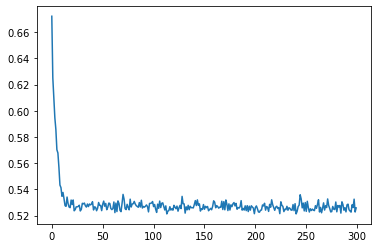

In [21]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list)

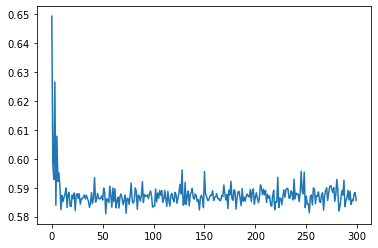

In [22]:
plt.plot(val_loss_list)

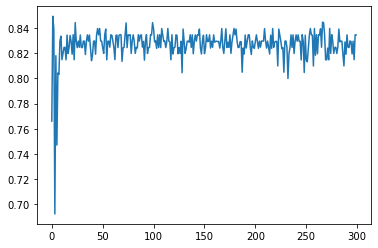

In [23]:
plt.plot(val_acc_list)

In [24]:
print(max(val_acc_list))
print(val_acc_list.index(max(val_acc_list)))

0.849624060150376
1


## Inference

In [25]:
test_dataset = CustomDataset(test_df, None, test_transforms)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [26]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    preds = []
    threshold = 0.5
    
    with torch.no_grad():
        for img, tabular in tqdm(iter(test_loader)):
            img = img.float().to(device)
            tabular = tabular.float().to(device)
            
            model_pred = model(img, tabular)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            
            preds += model_pred.tolist()
    
    preds = np.where(np.array(preds) > threshold, 1, 0)
    
    return preds

In [27]:
m = ClassificationModel()
m.load_state_dict(torch.load('./MIL_clf_model_trained.pt'))

<All keys matched successfully>

In [28]:
preds = inference(m, test_loader, device)

  0%|          | 0/16 [00:00<?, ?it/s]

## Submission

In [29]:
submit = pd.read_csv('./sample_submission.csv')

In [30]:
submit['N_category'] = preds
submit.to_csv('./submit.csv', index=False)

In [31]:
# for i in infer_model.parameters():
#     print(i)

In [32]:
# for i in m.parameters():
#     print(i)

In [33]:
submit

,ID,N_category
0,BC_01_0011,1
1,BC_01_0220,0
2,BC_01_0233,0
3,BC_01_0258,0
4,BC_01_0260,1
...,...,...
245,BC_01_3328,1
246,BC_01_3404,0
247,BC_01_3418,0
248,BC_01_3438,0


In [34]:
answer = pd.read_csv('./answer.csv') #0.8 score

cnt = 0

for i,j in zip(submit['N_category'],answer['N_category']):
    if i!=j:
        print(i,j)
        cnt+=1
print(cnt)

1 0
1 0
1 0
1 0
1 0
1 0
0 1
0 1
1 0
1 0
0 1
1 0
0 1
0 1
1 0
1 0
1 0
0 1
1 0
0 1
1 0
1 0
1 0
1 0
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
1 0
1 0
0 1
0 1
0 1
0 1
0 1
0 1
0 1
49


In [35]:
def test_validation(model, val_loader, device):
    model.eval()
    pred_labels = []
    true_labels = []
    threshold = 0.5
    with torch.no_grad():
        #for img, tabular, label in tqdm(iter(val_loader)):
        for img, tabular, label in val_loader:
            true_labels += label.tolist()
            
            #print(label.tolist())
            
            img = img.float().to(device)
            tabular = tabular.float().to(device)
            label = label.float().to(device)
            
            model_pred = model(img, tabular)
            
            #loss = criterion(model_pred, label.reshape(-1,1))
            
            #val_loss.append(loss.item())
            
            model_pred = model_pred.squeeze(1).to('cpu')  
            #print(model_pred.tolist())
            
            pred_labels += model_pred.tolist()
            
    
    pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
    #print(pred_labels)
    val_score = metrics.f1_score(y_true=true_labels, y_pred=pred_labels, average='macro')
    return val_score

In [36]:
v_list = []

for i in tqdm(range(100)):
    train_df = pd.read_csv('./train.csv')
    test_df = pd.read_csv('./test.csv')

    train_df['암의 장경'] = train_df['암의 장경'].fillna(train_df['암의 장경'].mean())
    train_df = train_df.fillna(0)

    test_df['암의 장경'] = test_df['암의 장경'].fillna(train_df['암의 장경'].mean())
    test_df = test_df.fillna(0)

    train_df, val_df, train_labels, val_labels = train_test_split(
                                                        train_df.drop(columns=['N_category']), 
                                                        train_df['N_category'], 
                                                        test_size=0.2, 
                                                        random_state=i,
                                                        #stratify=train_df['N_category']

                                                    )

    val_dataset = CustomDataset(val_df, val_labels.values, test_transforms)
    val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

    #criterion = nn.BCEWithLogitsLoss().to(device)
    #print(device)
    #preds = inference(m, test_loader, device)
    val_sc = test_validation(m, val_loader, device)
    #print(val_sc)
    v_list.append(val_sc)
    #print(len(val_sc))
    #print(val_score)

  0%|          | 0/100 [00:00<?, ?it/s]

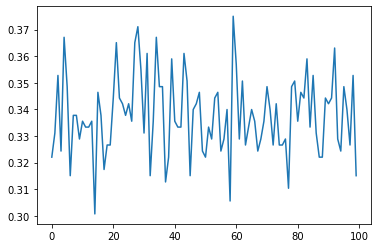

In [37]:
plt.plot(v_list)

In [39]:
print("최대",max(v_list),v_list.index(max(v_list)))
print("최소",min(v_list),v_list.index(min(v_list)))
print("평균",sum(v_list) / len(v_list))
print("분산", np.var(v_list))
print("표준편차", np.std(v_list))

최대 0.37499999999999994 59
최소 0.30069930069930073 14
평균 0.3377702197933705
분산 0.00021668198969641432
표준편차 0.01472012193211776
